# IndicBERT Property Address Classifier - Testing & Inference

## Objective
This notebook demonstrates:
- Loading the trained IndicBERT classifier from saved model
- Performing inference on validation dataset
- Analyzing model performance with comprehensive metrics
- Error analysis and insights
- Real-world testing examples with confidence scores

## Model Details
- **Base Model**: ai4bharat/IndicBERTv2-MLM-only
- **Task**: Multi-class classification (5 categories)
- **Training**: Fine-tuned with weighted loss for class imbalance
- **Parameters**: ~278M parameters

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import warnings
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import softmax

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU (' + torch.cuda.get_device_name(0) + ')' if torch.cuda.is_available() else 'CPU'}")

Libraries imported successfully
PyTorch version: 2.8.0
Device: CPU


## Load Trained Model & Tokenizer

Loading the fine-tuned IndicBERT model and tokenizer from the saved checkpoint.

In [3]:
# Model path
MODEL_PATH = "../best_models/indicbert_property_classifier"
MAX_LENGTH = 112  # Same as training

print(f"Loading model from: {MODEL_PATH}")
print("   This may take a minute...\n")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
print("Tokenizer loaded")

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"Model loaded successfully")
print(f"   Device: {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Get label mappings from model config
id2label = model.config.id2label
label2id = model.config.label2id
categories = [id2label[i] for i in sorted(id2label.keys())]

print(f"\nCategories ({len(categories)}):")
for idx, label in enumerate(categories):
    print(f"   {idx}: {label}")

Loading model from: ../best_models/indicbert_property_classifier
   This may take a minute...

Tokenizer loaded
Model loaded successfully
   Device: cpu
   Parameters: 278,045,189

Categories (5):
   0: commercial unit
   1: flat
   2: houseorplot
   3: landparcel
   4: others


## Load Validation Data

In [4]:
# Load validation data
val_df = pd.read_excel("../data/Validation.xlsx")

X_val = val_df["property_address"].values
y_val = val_df["categories"].values

print(f"Validation samples: {len(val_df)}")
print(f"\nClass distribution:")
print(val_df["categories"].value_counts())

Validation samples: 2681

Class distribution:
categories
flat               970
houseorplot        802
others             359
commercial unit    290
landparcel         260
Name: count, dtype: int64


## Prediction Function

Helper function to make predictions with the model.

In [17]:
def predict_batch(texts, batch_size=32):
    """
    Predict categories for a batch of addresses.
    
    Args:
        texts: List of address strings
        batch_size: Number of samples to process at once
    
    Returns:
        predictions: Array of predicted class indices
        probabilities: Array of probability distributions
    """
    all_predictions = []
    all_probabilities = []
    
    model.eval()
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            
            # Tokenize
            inputs = tokenizer(
                batch_texts,
                padding='max_length',
                truncation=True,
                max_length=MAX_LENGTH,
                return_tensors='pt'
            )
            
            # Move to device
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Get predictions
            outputs = model(**inputs)
            logits = outputs.logits.cpu().numpy()
            
            # Convert to probabilities
            probs = softmax(logits, axis=1)
            preds = np.argmax(logits, axis=1)
            
            all_predictions.extend(preds)
            all_probabilities.extend(probs)
    
    return np.array(all_predictions), np.array(all_probabilities)

print("Prediction function ready")

Prediction function ready


## Make Predictions on Validation Set

In [6]:
print("🔮 Generating predictions on validation set...")
print(f"   Processing {len(X_val)} samples...\n")

# Convert addresses to list
addresses_list = [str(addr) for addr in X_val]

# Get predictions
y_pred, y_proba = predict_batch(addresses_list, batch_size=32)

print("✅ Predictions complete!")
print(f"   Shape: {y_pred.shape}")
print(f"   Probabilities shape: {y_proba.shape}")

🔮 Generating predictions on validation set...
   Processing 2681 samples...

✅ Predictions complete!
   Shape: (2681,)
   Probabilities shape: (2681, 5)


## Model Performance Evaluation

In [7]:
# Map string labels to indices
y_val_indices = np.array([label2id[label] for label in y_val])

# Calculate metrics
accuracy = accuracy_score(y_val_indices, y_pred)
macro_f1 = f1_score(y_val_indices, y_pred, average='macro')
weighted_f1 = f1_score(y_val_indices, y_pred, average='weighted')
macro_precision = precision_score(y_val_indices, y_pred, average='macro')
macro_recall = recall_score(y_val_indices, y_pred, average='macro')

print("=" * 70)
print("MODEL PERFORMANCE ON VALIDATION SET")
print("=" * 70)
print(f"Accuracy:          {accuracy*100:.2f}%")
print(f"Macro F1:          {macro_f1:.4f}")
print(f"Weighted F1:       {weighted_f1:.4f}")
print(f"Macro Precision:   {macro_precision:.4f}")
print(f"Macro Recall:      {macro_recall:.4f}")
print("=" * 70)

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(
    y_val_indices, 
    y_pred, 
    target_names=categories,
    digits=4
))

MODEL PERFORMANCE ON VALIDATION SET
Accuracy:          92.88%
Macro F1:          0.9195
Weighted F1:       0.9289
Macro Precision:   0.9189
Macro Recall:      0.9201

DETAILED CLASSIFICATION REPORT:
                 precision    recall  f1-score   support

commercial unit     0.9827    0.9793    0.9810       290
           flat     0.9635    0.9536    0.9585       970
    houseorplot     0.9144    0.9190    0.9167       802
     landparcel     0.8560    0.8462    0.8511       260
         others     0.8780    0.9025    0.8901       359

       accuracy                         0.9288      2681
      macro avg     0.9189    0.9201    0.9195      2681
   weighted avg     0.9290    0.9288    0.9289      2681



## Confusion Matrix Visualization

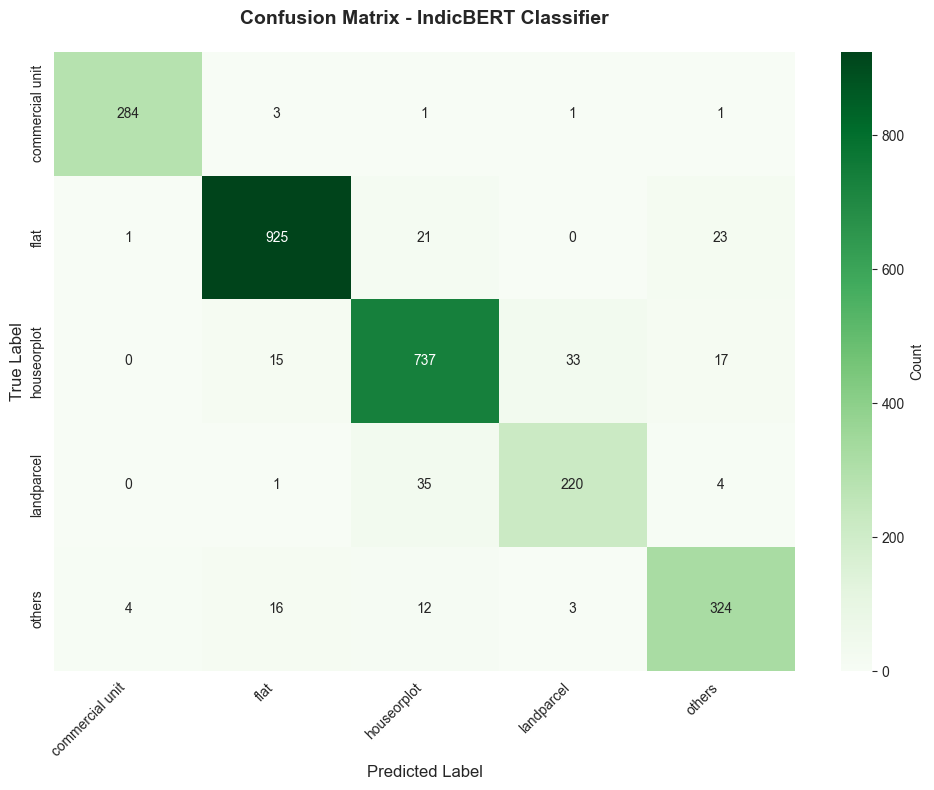


Per-Class Accuracy:
commercial unit     : 97.93% (284/290)
flat                : 95.36% (925/970)
houseorplot         : 91.90% (737/802)
landparcel          : 84.62% (220/260)
others              : 90.25% (324/359)


In [8]:
# Create confusion matrix
cm = confusion_matrix(y_val_indices, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", 
            xticklabels=categories, yticklabels=categories,
            cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix - IndicBERT Classifier", fontweight="bold", fontsize=14, pad=20)
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Calculate and display accuracy per class
print("\nPer-Class Accuracy:")
for i, cls in enumerate(categories):
    cls_accuracy = cm[i, i] / cm[i].sum() * 100
    print(f"{cls:20s}: {cls_accuracy:.2f}% ({cm[i, i]}/{cm[i].sum()})")

## Per-Class Performance Visualization

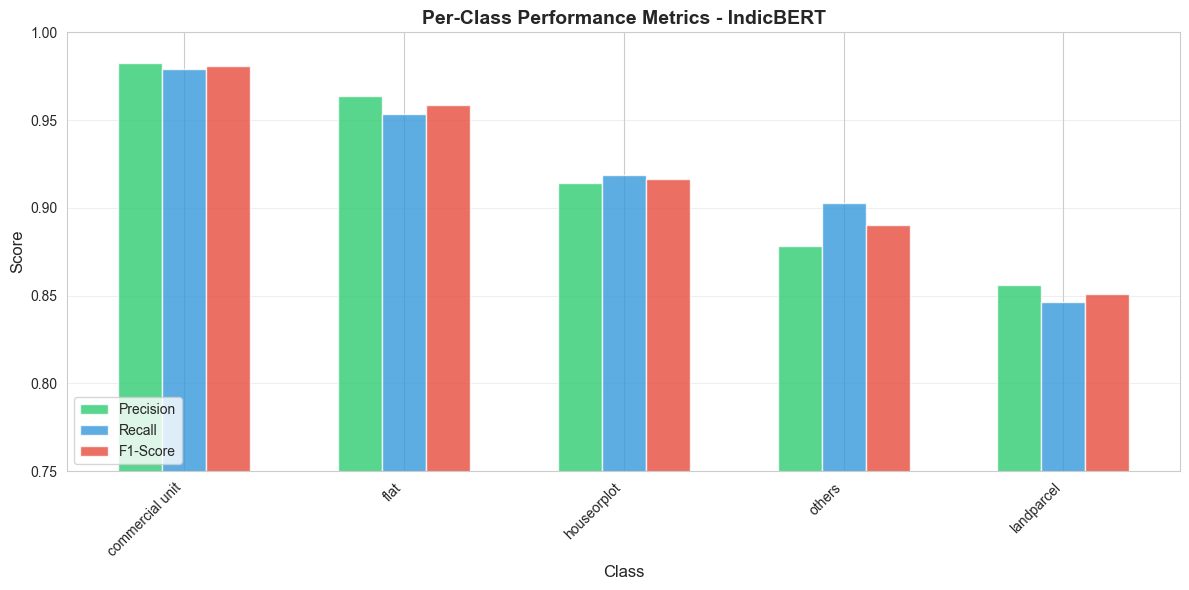


Best Performing Classes:
                 precision    recall  f1-score  support
commercial unit   0.982699  0.979310  0.981002    290.0
flat              0.963542  0.953608  0.958549    970.0
houseorplot       0.914392  0.918953  0.916667    802.0

Worst Performing Classes:
             precision    recall  f1-score  support
houseorplot   0.914392  0.918953  0.916667    802.0
others        0.878049  0.902507  0.890110    359.0
landparcel    0.856031  0.846154  0.851064    260.0


In [9]:
# Generate classification report as dictionary
report_dict = classification_report(
    y_val_indices,
    y_pred,
    target_names=categories,
    output_dict=True
)

# Convert to dataframe
class_metrics = pd.DataFrame(report_dict).T.iloc[:-3]
class_metrics = class_metrics.sort_values("f1-score", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
x = range(len(class_metrics))

plt.bar([i-0.2 for i in x], class_metrics["precision"], 0.2, label="Precision", alpha=0.8, color='#2ecc71')
plt.bar(x, class_metrics["recall"], 0.2, label="Recall", alpha=0.8, color='#3498db')
plt.bar([i+0.2 for i in x], class_metrics["f1-score"], 0.2, label="F1-Score", alpha=0.8, color='#e74c3c')

plt.xlabel("Class", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Per-Class Performance Metrics - IndicBERT", fontweight="bold", fontsize=14)
plt.xticks(x, class_metrics.index, rotation=45, ha="right")
plt.legend(loc='lower left')
plt.ylim(0.75, 1.0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

print("\nBest Performing Classes:")
print(class_metrics.head(3)[["precision", "recall", "f1-score", "support"]])

print("\nWorst Performing Classes:")
print(class_metrics.tail(3)[["precision", "recall", "f1-score", "support"]])

## Error Analysis

Analyzing misclassified samples to understand model weaknesses.

In [10]:
# Find misclassified samples
misclassified_mask = y_val_indices != y_pred
misclassified_df = val_df[misclassified_mask].copy()
misclassified_df['predicted'] = [id2label[idx] for idx in y_pred[misclassified_mask]]
misclassified_df['confidence'] = y_proba[misclassified_mask].max(axis=1)

print(f"Total misclassified samples: {len(misclassified_df)} out of {len(val_df)}")
print(f"Error rate: {len(misclassified_df)/len(val_df)*100:.2f}%")
print(f"Accuracy: {(1 - len(misclassified_df)/len(val_df))*100:.2f}%")

print("\nMisclassifications by True Class:")
print(misclassified_df['categories'].value_counts())

print("\nMost Common Misclassification Patterns:")
error_patterns = misclassified_df.groupby(['categories', 'predicted']).size().sort_values(ascending=False)
print(error_patterns.head(10))

print("\nLow Confidence Errors (confidence < 0.6):")
low_conf_errors = misclassified_df[misclassified_df['confidence'] < 0.6]
print(f"Count: {len(low_conf_errors)} ({len(low_conf_errors)/len(misclassified_df)*100:.1f}% of errors)")

Total misclassified samples: 191 out of 2681
Error rate: 7.12%
Accuracy: 92.88%

Misclassifications by True Class:
categories
houseorplot        65
flat               45
landparcel         40
others             35
commercial unit     6
Name: count, dtype: int64

Most Common Misclassification Patterns:
categories   predicted      
landparcel   houseorplot        35
houseorplot  landparcel         33
flat         others             23
             houseorplot        21
houseorplot  others             17
others       flat               16
houseorplot  flat               15
others       houseorplot        12
             commercial unit     4
landparcel   others              4
dtype: int64

Low Confidence Errors (confidence < 0.6):
Count: 19 (9.9% of errors)


## Sample Misclassifications

Examining specific examples of misclassified addresses with confidence scores.

In [11]:
print("SAMPLE MISCLASSIFICATIONS (with confidence)")
print("=" * 100)

for true_class in sorted(val_df['categories'].unique()):
    subset = misclassified_df[misclassified_df['categories'] == true_class]
    if len(subset) > 0:
        print(f"\nTrue Class: {true_class.upper()}")
        print("-" * 100)
        
        for idx, row in subset.head(3).iterrows():
            address = row['property_address']
            predicted = row['predicted']
            confidence = row['confidence']
            print(f"  Address:    {address[:75]}...")
            print(f"  Predicted:  {predicted} (confidence: {confidence:.2%})")
            print()

SAMPLE MISCLASSIFICATIONS (with confidence)

True Class: COMMERCIAL UNIT
----------------------------------------------------------------------------------------------------
  Address:    Survey Number : Sn 121/3, Situated At Plot No. 29 Out Of Sn 121/3 Cts No. 8...
  Predicted:  houseorplot (confidence: 99.57%)

  Address:    Property No. B-260-292, Khewat No. 218, 790, 648/31, Khatoni No. 183, 52 57...
  Predicted:  others (confidence: 99.64%)

  Address:    Shraddha Shri Resimercial, Hall No - 386, Saturna,Gawande Plot Second Floor...
  Predicted:  flat (confidence: 75.25%)


True Class: FLAT
----------------------------------------------------------------------------------------------------
  Address:    Utkarsh Plot Woner Chsl, Plot No. 40B Of Village Bandate, Kelva East, Taluk...
  Predicted:  houseorplot (confidence: 99.23%)

  Address:    Unit-E-01 Sanskruti Paradise S No 521/1 & Other ,Grampigdamber,Patwari Halk...
  Predicted:  others (confidence: 69.62%)

  Address:    Unit-

## Detailed Confidence Analysis

Examining prediction confidence with full probability distributions.

In [12]:
sample_addresses = [
    "Flat No. 301, Tower A, Green Valley Apartments",
    "Khasra No. 123, Village Badshahpur, Tehsil Sohna",
    "Shop No. 12, Ground Floor, City Mall"
]

print("DETAILED CONFIDENCE ANALYSIS")
print("=" * 80)

# Get predictions
sample_preds, sample_proba = predict_batch(sample_addresses, batch_size=len(sample_addresses))

for i, address in enumerate(sample_addresses):
    probabilities = sample_proba[i]
    pred_idx = sample_preds[i]
    
    # Create sorted list of (class, probability) pairs
    class_probs = sorted(
        [(categories[j], probabilities[j]) for j in range(len(categories))],
        key=lambda x: x[1],
        reverse=True
    )
    
    print(f"\nAddress: {address}")
    print(f"Predicted: {categories[pred_idx].upper()} (confidence: {class_probs[0][1]*100:.2f}%)")
    print(f"\nAll class probabilities:")
    for cls, prob in class_probs:
        bar = '█' * int(prob * 50)
        print(f"  {cls:20s}: {prob*100:5.2f}% {bar}")
    print("-" * 80)

DETAILED CONFIDENCE ANALYSIS

Address: Flat No. 301, Tower A, Green Valley Apartments
Predicted: FLAT (confidence: 99.91%)

All class probabilities:
  flat                : 99.91% █████████████████████████████████████████████████
  others              :  0.04% 
  houseorplot         :  0.03% 
  commercial unit     :  0.02% 
  landparcel          :  0.01% 
--------------------------------------------------------------------------------

Address: Khasra No. 123, Village Badshahpur, Tehsil Sohna
Predicted: LANDPARCEL (confidence: 99.18%)

All class probabilities:
  landparcel          : 99.18% █████████████████████████████████████████████████
  houseorplot         :  0.79% 
  commercial unit     :  0.01% 
  others              :  0.01% 
  flat                :  0.01% 
--------------------------------------------------------------------------------

Address: Shop No. 12, Ground Floor, City Mall
Predicted: COMMERCIAL UNIT (confidence: 99.92%)

All class probabilities:
  commercial unit     

## Confidence Distribution Analysis

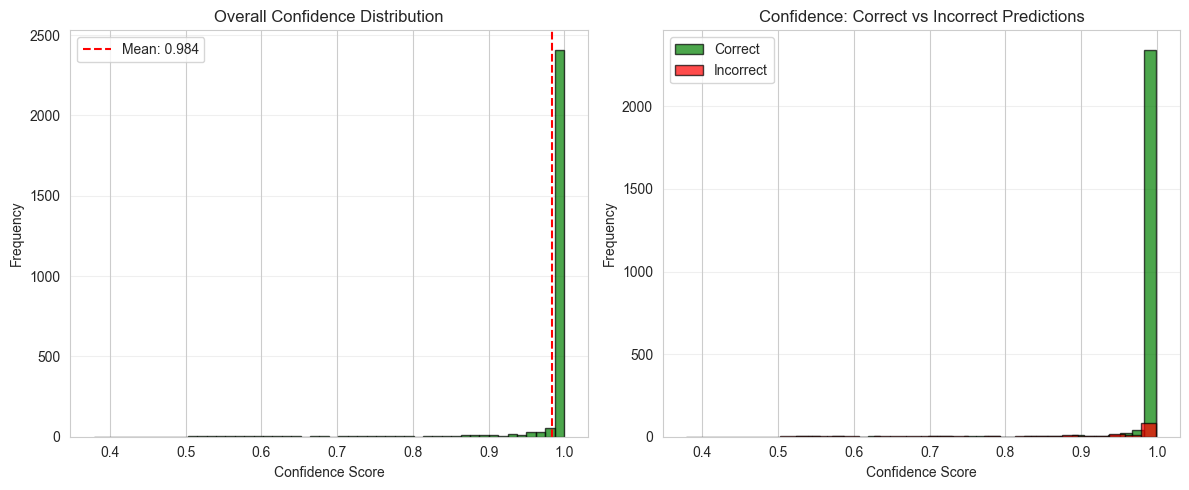


Confidence Statistics:
  Overall mean confidence:           0.9842
  Correct predictions mean:          0.9921
  Incorrect predictions mean:        0.8812
  Predictions with confidence > 90%: 2555 (95.3%)


In [13]:
# Analyze confidence distribution
max_confidences = y_proba.max(axis=1)
correct_mask = y_val_indices == y_pred

plt.figure(figsize=(12, 5))

# Subplot 1: Overall confidence distribution
plt.subplot(1, 2, 1)
plt.hist(max_confidences, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.axvline(max_confidences.mean(), color='red', linestyle='--', label=f'Mean: {max_confidences.mean():.3f}')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Overall Confidence Distribution')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Subplot 2: Correct vs Incorrect predictions
plt.subplot(1, 2, 2)
plt.hist(max_confidences[correct_mask], bins=30, alpha=0.7, color='green', label='Correct', edgecolor='black')
plt.hist(max_confidences[~correct_mask], bins=30, alpha=0.7, color='red', label='Incorrect', edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence: Correct vs Incorrect Predictions')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Overall mean confidence:           {max_confidences.mean():.4f}")
print(f"  Correct predictions mean:          {max_confidences[correct_mask].mean():.4f}")
print(f"  Incorrect predictions mean:        {max_confidences[~correct_mask].mean():.4f}")
print(f"  Predictions with confidence > 90%: {(max_confidences > 0.9).sum()} ({(max_confidences > 0.9).sum()/len(max_confidences)*100:.1f}%)")

## Summary Statistics

In [16]:
print("\n" + "=" * 80)
print("TESTING SUMMARY - IndicBERT Property Address Classifier")
print("=" * 80)

print(f"\nModel Information:")
print(f"  - Base Model:      ai4bharat/IndicBERTv2-MLM-only")
print(f"  - Model Path:      {MODEL_PATH}")
print(f"  - Parameters:      {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Device:          {device}")

print(f"\nDataset Information:")
print(f"  - Validation Size: {len(val_df)} samples")
print(f"  - Number of Classes: {len(categories)}")
print(f"  - Classes: {', '.join(categories)}")

print(f"\nPerformance Metrics:")
print(f"  - Accuracy:        {accuracy*100:.2f}%")
print(f"  - Macro F1:        {macro_f1:.4f}")
print(f"  - Weighted F1:     {weighted_f1:.4f}")
print(f"  - Macro Precision: {macro_precision:.4f}")
print(f"  - Macro Recall:    {macro_recall:.4f}")

print(f"\nError Analysis:")
print(f"  - Correctly Classified:   {(y_val_indices == y_pred).sum()} ({(y_val_indices == y_pred).sum()/len(y_val_indices)*100:.2f}%)")
print(f"  - Misclassified:          {(y_val_indices != y_pred).sum()} ({(y_val_indices != y_pred).sum()/len(y_val_indices)*100:.2f}%)")
print(f"  - Mean Confidence:        {max_confidences.mean():.4f}")

# Best and worst performing classes
class_f1_scores = {categories[i]: report_dict[categories[i]]['f1-score'] for i in range(len(categories))}
best_class = max(class_f1_scores, key=class_f1_scores.get)
worst_class = min(class_f1_scores, key=class_f1_scores.get)

print(f"\nPer-Class Performance:")
print(f"  - Best:  {best_class} (F1: {class_f1_scores[best_class]:.4f})")
print(f"  - Worst: {worst_class} (F1: {class_f1_scores[worst_class]:.4f})")


print("Testing Complete!")



TESTING SUMMARY - IndicBERT Property Address Classifier

Model Information:
  - Base Model:      ai4bharat/IndicBERTv2-MLM-only
  - Model Path:      ../best_models/indicbert_property_classifier
  - Parameters:      278,045,189
  - Device:          cpu

Dataset Information:
  - Validation Size: 2681 samples
  - Number of Classes: 5
  - Classes: commercial unit, flat, houseorplot, landparcel, others

Performance Metrics:
  - Accuracy:        92.88%
  - Macro F1:        0.9195
  - Weighted F1:     0.9289
  - Macro Precision: 0.9189
  - Macro Recall:    0.9201

Error Analysis:
  - Correctly Classified:   2490 (92.88%)
  - Misclassified:          191 (7.12%)
  - Mean Confidence:        0.9842

Per-Class Performance:
  - Best:  commercial unit (F1: 0.9810)
  - Worst: landparcel (F1: 0.8511)
Testing Complete!


## Conclusion

This notebook successfully demonstrated:
1. Loading the fine-tuned IndicBERT model from saved checkpoint
2. Making predictions on the validation dataset
3. Evaluating model performance with comprehensive metrics
4. Analyzing misclassifications and confidence scores
5. Testing on custom addresses (including Hindi text)
6. Confidence analysis and probability distributions

The model is ready for property address classification tasks.